In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm
import os
import time
from tensorboardX import SummaryWriter

#from envs.burgers import Burgers
from buffer import OfflineReplayBuffer
#from critic import ValueLearner, QPiLearner, QSarsaLearner
from bppo import BehaviorCloning, BehaviorProximalPolicyOptimization

In [2]:
# Hyperparameters

# Experiment
env_name='burger'
path='logs'
log_freq=int(100)
seed=20241219
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
N=100 # Number of trajectories to collect for offline dataset

# For Value
v_steps=int(5000)
v_hidden_dim = 256
v_depth = 3
v_lr = 1e-6
v_batch_size = 64

# For Q
q_bc_steps=int(5000)
q_pi_steps=10 # Number of steps to update Q-network in each iteration. Only used if is_offpolicy_update=True.
q_hidden_dim = 256
q_depth = 3
q_lr = 1e-6
q_batch_size = 64
target_update_freq=2
tau=0.005 # Soft update rate for target Q network parameters. See Q_learner.update()
gamma=0.99 # Discount factor for calculating the return.
is_offpolicy_update=False # Whether to use advantage replacement (as proposed in the BPPO paper) in Q-learning.
# If False, use Q-learning to update the Q-network parameters in each iteration.
# If True, only update the Q-network parameters once, and keep using this Q-network.

# For BC
bc_steps=int(500)
bc_lr = 1e-4
bc_hidden_dim = 256
bc_depth = 3
bc_batch_size = 64

# For BPPO
bppo_steps=int(100)
bppo_hidden_dim = 256
bppo_depth = 3
bppo_lr = 1e-4
bppo_batch_size = 64
clip_ratio=0.25 # PPO clip ratio. The probability ratio between new and old policy is clipped to be in the range [1-clip_ratio, 1+clip_ratio]
entropy_weight=0.00 # Weight of entropy loss in PPO and BPPO. Can be set to 0.01 for medium tasks.
decay=0.96 # Decay rate of PPO clip ratio
omega=0.9 # Related to setting the weight of advantage (see PPO code)
is_clip_decay=True # Whether to decay the clip_ratio during training
is_bppo_lr_decay=True # Whether to decay the learning rate of BPPO during trainining
is_update_old_policy=True # Whether to update the old policy of BPPO in each iteration. The old policy is used to calculate the probability ratio.
is_state_norm=False # Whether to normalize the states of the dataset.

# Other Settings
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device=torch.device('cpu')
state_dim = 128
action_dim = 128
x_range=(-5,5)



In [3]:
from generate_burgers import load_burgers

dataset = load_burgers(
                x_range=x_range,
                nt = 500, # Number of time steps
                nx = state_dim, # Number of spatial nodes (grid points)
                dt= 0.001, # Temporal interval
                N = 1, # Number of samples (trajectories) to generate
                visualize=False # Whether to show the animation of state trajectory evolution
                )

for key in dataset.keys():
    if key!="meta_data":
        dataset[key]=dataset[key].squeeze(0)

print(dataset['observations'].shape)
print(dataset['actions'].shape)
print(dataset['rewards'].shape)
print(dataset['terminals'].shape)
print(dataset['timeouts'].shape)

Setting rewards: 100%|██████████| 1/1 [00:00<?, ?it/s]

Y_bar shape:  (1, 500, 128)
Y_f shape:  (1, 128)
U shape:  (1, 500, 128)
Terminals shape:  (1, 500)
Timeouts shape:  (1, 500)
Rewards shape:  (1, 500)
(500, 128)
(500, 128)
(500,)
(500,)
(500,)


In [4]:
replay_buffer = OfflineReplayBuffer(device, state_dim, action_dim, len(dataset['actions']))
replay_buffer.load_dataset(dataset=dataset)
replay_buffer.compute_return(gamma) # Compute the discounted return for the trajectory, with a discount factor of gamma (default 0.99).

Computing the returns: 499it [00:00, 140778.75it/s]


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

class ValueLearner1(nn.Module):
    def __init__(
        self,
        state_dim: int, 
        hidden_dim: int, 
        depth: int, 
    ) -> None:
        super().__init__()
        #self._device = device


        '''
        layers = [nn.Linear(state_dim, hidden_dim), nn.ReLU()]
        for _ in range(depth -1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 1))
        #layers.append(nn.ReLU())
    
        self.net = nn.Sequential(*layers).to(device)
        '''
        self.layer1=nn.Linear(state_dim,hidden_dim).to(device)
        self.relu1=nn.ReLU().to(device)
        self.layer2=nn.Linear(hidden_dim,1).to(device)
        

    def forward(self,
        s: torch.Tensor
    ) -> torch.Tensor:
        s = self.layer1(s)
        s = self.relu1(s)
        s = self.layer2(s)
        return s

    '''
    def save(
        self, path: str
    ) -> None:
        torch.save(self.state_dict(), path)
        print('Value parameters saved in {}'.format(path))


    def load(
        self, path: str
    ) -> None:
        self.load_state_dict(torch.load(path, map_location=self._device))
        print('Value parameters loaded')

    '''

value_learner = ValueLearner1(
                        state_dim=state_dim,
                        hidden_dim=64,
                        depth=v_depth,)

In [21]:
print(v_hidden_dim)

256


In [22]:
# value training 
#value_learner=MLP(input_size, hidden_size, output_size)
#value_path = os.path.join(path, 'value.pt')
if os.path.exists(value_path):
    pass
    #value_learner.load(value_path)
else:
    criterion = nn.MSELoss()  # 均方误差损失
    optimizer = optim.Adam(value_learner.parameters(), lr=1e-3)
    for step in tqdm.tqdm(range(int(v_steps)), desc='value updating ......'):
        value_learner.train()  # 设置模型为训练模式
        s, _, _, _, _, _, Return, _ = replay_buffer.sample(128)
        # 前向传播
        outputs = value_learner(s)
        loss = criterion(outputs, Return)

        # 反向传播和优化
        optimizer.zero_grad()  # 清空之前的梯度
        loss.backward()        # 计算梯度
        optimizer.step()       # 更新参数
        
        if step % int(log_freq) == 0:
            print(f"Step: {step}, Loss: {loss.item():.4f}")
            #logger.add_scalar('value_loss', loss, global_step=(step+1))
    #value_learner.save(value_path)

value updating ......:   2%|▏         | 99/5000 [00:00<00:09, 514.44it/s]

Step: 0, Loss: 404.4404


value updating ......:   3%|▎         | 168/5000 [00:00<00:08, 589.02it/s]

Step: 100, Loss: 466.3552
Step: 200, Loss: 123.7006


value updating ......:   8%|▊         | 376/5000 [00:00<00:07, 645.77it/s]

Step: 300, Loss: 39.2764
Step: 400, Loss: 18.2187


value updating ......:  12%|█▏        | 580/5000 [00:00<00:06, 650.15it/s]

Step: 500, Loss: 10.2800
Step: 600, Loss: 6.9644


value updating ......:  16%|█▌        | 795/5000 [00:01<00:06, 651.80it/s]

Step: 700, Loss: 6.2628
Step: 800, Loss: 2.6346


value updating ......:  20%|██        | 1006/5000 [00:01<00:05, 680.74it/s]

Step: 900, Loss: 1.0923
Step: 1000, Loss: 1.2449


value updating ......:  24%|██▍       | 1218/5000 [00:01<00:05, 692.51it/s]

Step: 1100, Loss: 1.1982
Step: 1200, Loss: 0.8332


value updating ......:  27%|██▋       | 1354/5000 [00:02<00:05, 639.07it/s]

Step: 1300, Loss: 0.6706


value updating ......:  30%|██▉       | 1487/5000 [00:02<00:05, 597.55it/s]

Step: 1400, Loss: 0.2854
Step: 1500, Loss: 0.2902


value updating ......:  34%|███▍      | 1699/5000 [00:02<00:04, 661.16it/s]

Step: 1600, Loss: 0.2521
Step: 1700, Loss: 0.1717


value updating ......:  38%|███▊      | 1904/5000 [00:02<00:05, 590.94it/s]

Step: 1800, Loss: 0.1637
Step: 1900, Loss: 0.0991


value updating ......:  42%|████▏     | 2110/5000 [00:03<00:04, 648.83it/s]

Step: 2000, Loss: 0.0959
Step: 2100, Loss: 0.1120


value updating ......:  46%|████▋     | 2323/5000 [00:03<00:03, 686.44it/s]

Step: 2200, Loss: 0.1176
Step: 2300, Loss: 0.0519


value updating ......:  49%|████▉     | 2460/5000 [00:03<00:04, 579.69it/s]

Step: 2400, Loss: 0.0430


value updating ......:  52%|█████▏    | 2588/5000 [00:04<00:03, 607.19it/s]

Step: 2500, Loss: 0.1385
Step: 2600, Loss: 0.0239


value updating ......:  56%|█████▌    | 2782/5000 [00:04<00:03, 630.90it/s]

Step: 2700, Loss: 0.0272
Step: 2800, Loss: 0.0331


value updating ......:  60%|█████▉    | 2992/5000 [00:04<00:03, 667.43it/s]

Step: 2900, Loss: 0.0473
Step: 3000, Loss: 0.0259


value updating ......:  64%|██████▍   | 3199/5000 [00:04<00:02, 653.09it/s]

Step: 3100, Loss: 0.0107
Step: 3200, Loss: 0.0219


value updating ......:  65%|██████▌   | 3260/5000 [00:05<00:02, 637.54it/s]


KeyboardInterrupt: 

Epoch [100/1000], Loss: 340.0782
Epoch [200/1000], Loss: 103.4632
Epoch [300/1000], Loss: 64.0919
Epoch [400/1000], Loss: 15.3414
Epoch [500/1000], Loss: 8.2938
Epoch [600/1000], Loss: 7.2583
Epoch [700/1000], Loss: 2.6440
Epoch [800/1000], Loss: 3.5308
Epoch [900/1000], Loss: 2.9832
Epoch [1000/1000], Loss: 1.7698


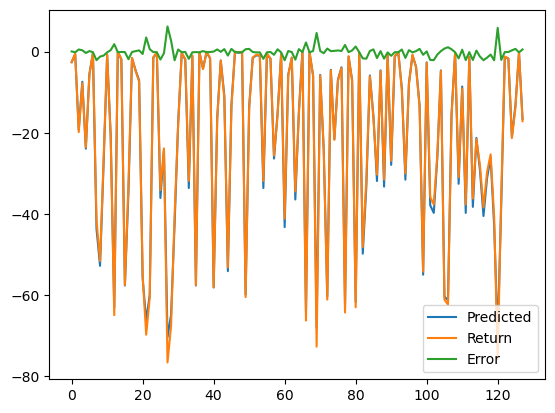

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义MLP模型
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 设置超参数
input_size = 128   # 输入特征维度
hidden_size = 64   # 隐藏层神经元数量
output_size = 1    # 输出维度
num_epochs = 1000  # 训练轮数
learning_rate = 0.001  # 学习率

# 创建模型、损失函数和优化器
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # 均方误差损失
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 假设s和Return已经是PyTorch张量
# s形状为(1000, 128)，Return形状为(1000, 1)

# 训练模型
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    s, _, _, _, _, _, Return, _ = replay_buffer.sample(128)
    # 前向传播
    outputs = model(s)
    loss = criterion(outputs, Return)

    # 反向传播和优化
    optimizer.zero_grad()  # 清空之前的梯度
    loss.backward()        # 计算梯度
    optimizer.step()       # 更新参数

    # 打印损失
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 训练完成后，可以使用模型进行预测
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    predicted = model(s)  # 通过训练好的模型进行预测

plt.plot(predicted.detach().numpy(), label='Predicted')
plt.plot(Return.numpy(), label='Return')
plt.plot(predicted.detach().numpy()-Return.numpy(), label='Error')
plt.legend()
plt.show()